# Star Warsify yourself!
<img src="https://media.giphy.com/media/IuHrBkXpWPTCKa6qNG/giphy.gif" width="1000" height="600"/>

This notebook demonstrates how to use state-of-the-art machine learning techniques with AMD compute accelerators and Rocm for training by modifying Nvidia's styleGun2.

## What is styleGun2.
styleGun2 was developed by Nvidia's research department and currently represents the state of art in synthetic image generation. It is capable of generating photorealistic images that are indistinguishable from real image. It is based on the Generative Adversarial Network (GAN) architecture. What is GAN? It is two networks trying to compete with each other: the generator and the discriminator. The generator tries to fool the discriminator into thinking its generated image is real, while the discriminator tries to distinguish between the real image and the fake (generated) image.

![Alt Text](https://miro.medium.com/max/1741/1*t78gwhhw-hn1CgXc1K89wA.png)

The discriminator is first trained by showing it the real image from the dataset and random noise (image from the untrained generator). Since the data distribution is very different, the discriminator will be able to distinguish easily.

We will then proceed to train the generator while freezing the discriminator. The generator will learn how to produce better images based on the discriminator's output (real or fake) until the discriminator can no longer discriminate correctly. Then we switch back to training the discriminator, and the cycle continues, both getting better until the generator reaches the point of producing a very realistic image, and training can be stopped.


Now that we've developed some understanding of what a gan is, let's go back to NVIDIA's styleGun2 and see what makes it unique and allows it to perform so well; One of the innovations is that it unravels latent space, which will enable us to control attributes at a different level. For example, the lower level might control the pose and head shape, while the higher-level controls higher-level features such as lighting or texture. The disentanglement is done by introducing an additional mapping network that maps the input z (noise/*random* vector sampled from a normal distribution) to a separate vector w and feeds it to different layers. Consequently, each part of the z input controls a different layer of features

![Alt Text](https://miro.medium.com/max/3484/1*iTf9srf5HczqVv26U7Ah_Q.png)
So if we want to change some features in the generated image, we can simply change the inputs in the lower layers to achieve variations in the high-level features, such as the head shape, hairstyle, and pose. This will come in handy later in our project.

![Alt Text](https://miro.medium.com/max/1400/0*eDxrKvi8mgkcrEk2.png)

In addition, we can also modify the input of the higher layers (higher resolution 256X256 example) we can get variations in the finer features like the light intensity, skin, hair colour etc.

![Alt Text](https://miro.medium.com/max/1400/0*hdRS8wWRg7g5g3fW.png)


Moreover, we can visualise the disentanglement to further illustrate which layers control which features of the image of with spherical K-Means clustering.


![Alt Text](https://miro.medium.com/max/1158/1*gL7_JDI-cXU9CSEoevoZSg.png)

The colour represents a formed cluster, which you can think of as the controllable part of the image. In the last layer, you can see that different lighting parts are represented as separate clusters. In the middle layers, the facial features such as eye, nose or mouth are described as other clusters, which means that the variations of facial features are controlled here. Finally, in the first layers, different head parts are represented as different clusters, which proves that the shape, pose, and hairstyle of the person are controlled here.


## StyleGAN Network Blending

The unique disentanglement of features in StyleGAN allows us to mix different models and create a Star Wars like character. If the first few layers control the facial features and the last layers contain the texture, what happens if we swap the last layers with the layers of another model?
For example, if we use the face model's weights for the first few layers and the model Star Wars 's weights for the remaining layers, the face will be created with the Star Wars style! Also, the texture of the second model and the type of facial features of the different models can be copied, e.g. the eye or the mouth of the Star Wars character


Okay, let's get started with the project, first clone the repository and install all the necessary dependencies.

In [ ]:
!git clone https://github.com/ferdinandl007/Northern-Data-Star-Wars-GAN.git
%cd /content/Northern-Data-Star-Wars-GAN/DatasetGenerator
!pip install --upgrade pip
!pip install -r requirements.txt

# Data Generation
The project includes a DataSet generation tool that can generate a DataSet of faces from YouTube videos - all you need to do is enter the URLs, and it will do the rest
At this step, you have three options: You can either generate a new dataset with your own custom URLs, but make sure you provide at least three hours of video content, or you can generate the dataset with the default URLs of Star Wars the clone wars videos, and finally, you can just download all the process data I prepared for you!






In [ ]:
from GenerateDataset import GenerateDataset
you_video_urls = []
dataset_generator = GenerateDataset(every_x_frame=13, set_fix_image_size=256, video_urls=you_video_urls)
dataset_generator.run()


In [ ]:
from GenerateDataset import GenerateDataset
dataset_generator = GenerateDataset(every_x_frame=13, set_fix_image_size=256)
dataset_generator.run()

Alternatively download the Star Wars the clone wars DataSet here!

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/DatasetGenerator/
!wget https://www.dropbox.com/s/v6ffbfof26byuy1/faces.zip
from zipfile import ZipFile
zf = ZipFile('faces.zip', 'r')
zf.extractall()
zf.close()


# DataSet preparation
Now that we have the dataset ready, we need to convert it to a DataFrame that Tenser Flow and styleGan can understand - in this case, it's a tfrecord
![Alt Text](https://storage.googleapis.com/kf-pipeline-contrib-public/release-0.1.1/kfp-components/data_converter/preprocessing_image/assets/image.png)


In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/DatasetGenerator/faces
!python3 /content/Northern-Data-Star-Wars-GAN/stylegan2/dataset_tool.py create_from_images_raw /content/Northern-Data-Star-Wars-GAN/stylegan2/dataset/starWars .

Download the previously trained stylegan2 networks that we will use for transfer learning and network blending

# training custom styleGan network
Finally we get to the interesting part, training your own styleGan network. But beware, this may take a while 😬. For are project, we want to tune a network that was previously trained to generate human faces so that it now generates Star Wars characters that we can later use for network blending.


As mentioned earlier, Justin Pinkney introduced a concept I called "layer swapping" to mix two StyleGAN models. The goal was to mix a base model and another that was created from it using transfer learning, the fine-tuned model. The method was different than simply interpolating the weights of the two models because it allows you to independently control which model you get the low and high resolution features from; 
Here is an example using this technique to get the pose from normal photos and the texture/style from ukiyo-e prints
![link text](https://www.justinpinkney.com/static/eab0821e721edd413d95de86fc04b35a/b17f8/mr79.jpg)


Note: Once the training is running, you should cheque the results in "/content/Northern-Data-Star-Wars- GAN /results" and stop the training if you are satisfied with the results. 
Then copy the last ".pkl" into the directory stylegan2

PS:
But don't worry, if the training takes too long, I'll have a pre-trained model for you later in the project.




In [ ]:
# download pre-trained model for transfer learning
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
!wget https://www.dropbox.com/s/f7ts2pdg7ml2fjd/ffhq-256-config-e-003810.pkl

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
!python3 run_training.py --num-gpus=1 --data-dir=./dataset --config=config-f --minibatch-gpu-base=8 --dataset=starWars --min-h=3 --min-w=3 --res-log2=7 --mirror-augment=true --metric=none --total-kimg=500 --resume-pkl="/content/Northern-Data-Star-Wars-GAN/stylegan2/ffhq-256-config-e-003810.pkl" --result-dir="/content/Northern-Data-Star-Wars-GAN/results"

# Some cool example of network blending

In [ ]:
%%html
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Blending humans and cartoons using  @Buntworthy's Google Colab notebook. Thank you for that, it's awesome. Here is a YouTube version of this video: https://youtu.be/W-VRdE7zagw. <a href="https://t.co/qO5ySH2TxT">pic.twitter.com/qO5ySH2TxT</a></p>&mdash; Justin (@Buntworthy) <a href="https://twitter.com/Norod78/status/1297513475258953728?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1297513475258953728%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.justinpinkney.com%2Fstylegan-network-blending%2F">August 17, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

# Network blending
It's time to try out some network blending for ourselves. Let try some different resolutions for the switch and see the results. Remember that the Star Wars model provides the low resolution layers, i.e. the "structure", and the original surface model provides the high resolution, i.e. the "texture"

I'll run the main function in blend_models.py in a Python loop, but you can also run it from the command line, like this

Note: make sure to change "starWars.pkl" the path of your own trend ".pkl" file

In [ ]:
 # downloading the base face model we want to blend with
 !wget https://hanlab.mit.edu/projects/data-efficient-gans/models/stylegan2-ffhq.pkl

If you don't want to wait until the training is complete, you can use my pre-trained model, which you can easily download here!

In [ ]:
 !wget https://www.dropbox.com/s/69x1tur0b5kw3wx/star_wars_gun3.pkl

# Save blended model
When you are satisfied with the blended models you have just created, choose the resolution you like best and remember the model name it will be something like blended{res}.pkl.

Note: make sure to change "star_wars_gan2.pkl" the path of your own trend "blended{res}.pkl" file

/content/Northern-Data-Star-Wars-GAN/stylegan2
blending at 8x8
blended8.pkl


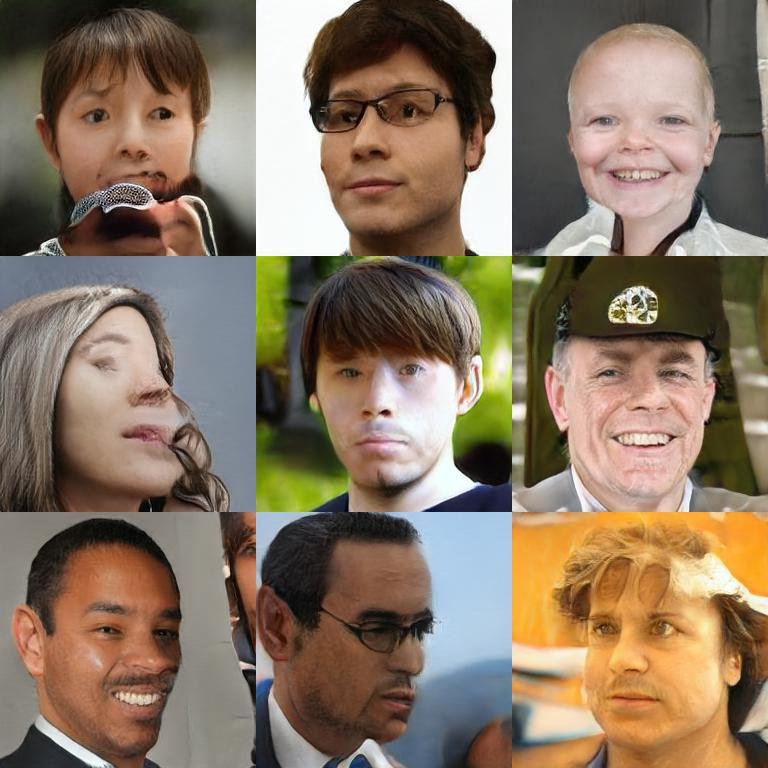

blending at 16x16
blended16.pkl


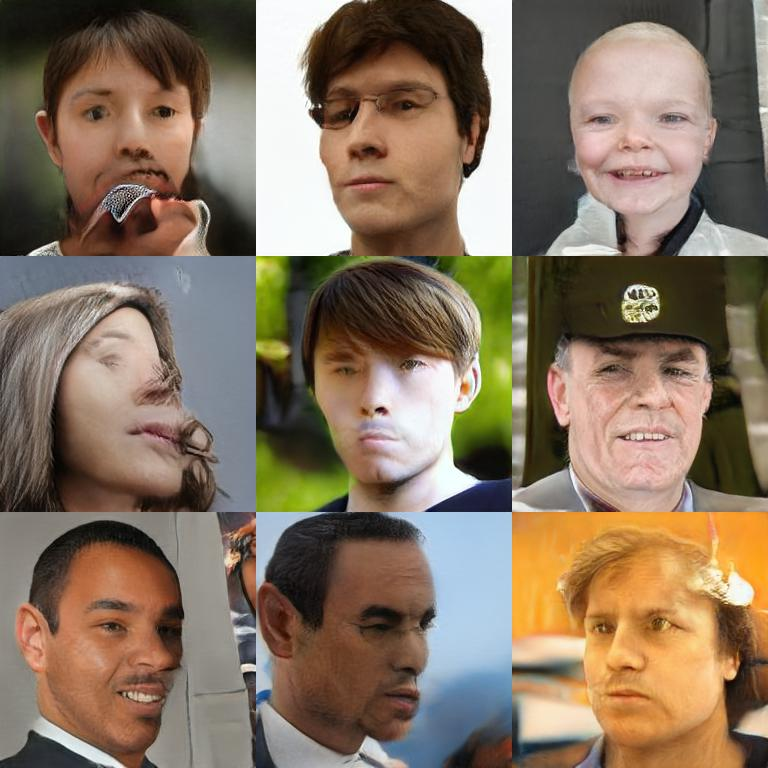

blending at 32x32
blended32.pkl


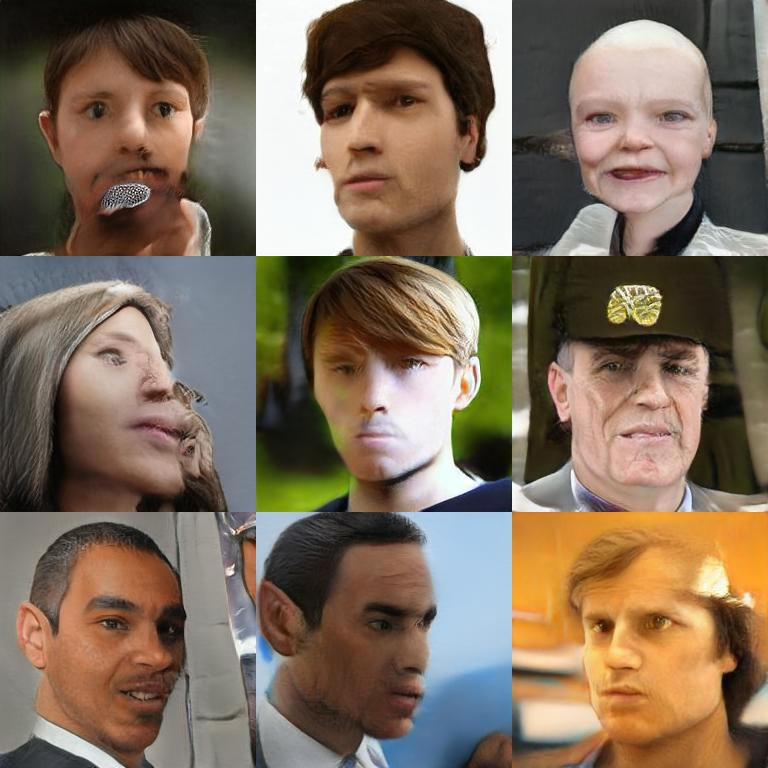

blending at 64x64
blended64.pkl


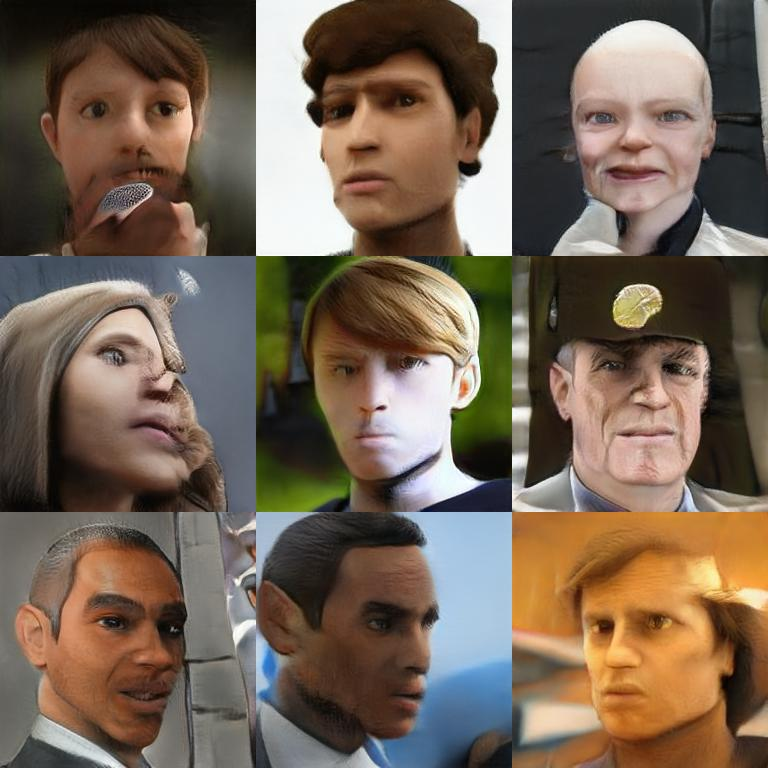

blending at 128x128
blended128.pkl


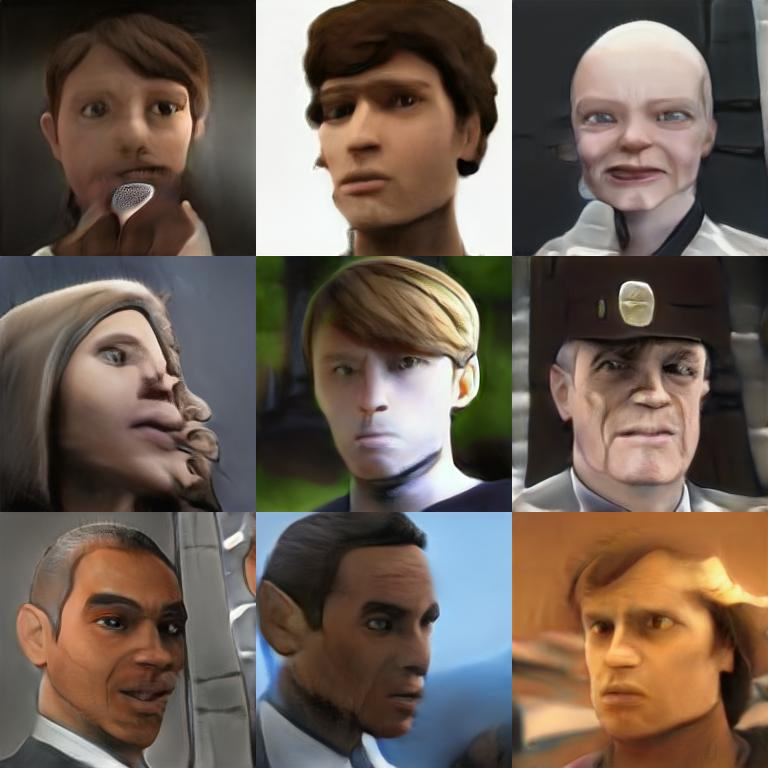

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
from IPython.display import Image 
import blend_models
resolutions = (8, 16, 32, 64, 128)
for res in resolutions:
  filename = f"blended-{res}.jpg"
  # if you have trained your own model replace "star_wars_gan2.pkl" what is the path to your model
  blend_models.main("star_wars_gan3.pkl", "ffhq-256-config-e-003810.pkl", res, output_grid=filename, output_pkl=f"blended{res}.pkl")
  img = Image(filename=filename)
  print(f"blending at {res}x{res}")
  print(f"blended{res}.pkl")
  display(img)

Let's make some directories which we will need later on

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
!mkdir aligned
!mkdir generate
!mkdir raw

/content/Northern-Data-Star-Wars-GAN/stylegan2


# download image
Let's download a picture we Star Warsify, if you want to Star Warsify yourself, replace the URL with one that points to a picture of yourself

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
!wget https://i.ibb.co/qJFHpMz/29cd1d26-481b-4fb2-b1df-587b821e4303.jpg -O raw/example.jpg

/content/Northern-Data-Star-Wars-GAN/stylegan2
--2021-02-24 20:21:56--  https://i.ibb.co/qJFHpMz/29cd1d26-481b-4fb2-b1df-587b821e4303.jpg
Resolving i.ibb.co (i.ibb.co)... 104.194.8.196, 172.96.140.18
Connecting to i.ibb.co (i.ibb.co)|104.194.8.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52861 (52K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>]  51.62K   338KB/s    in 0.2s    

2021-02-24 20:21:56 (338 KB/s) - ‘raw/example.jpg’ saved [52861/52861]



All we need to do now is some alignment to crop your face out of this picture so we get a good result 😉.

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
!python3 align_images.py raw aligned

/content/Northern-Data-Star-Wars-GAN/stylegan2


# create a projection of your face in latent space
So far we've generated random faces from random initialised latent vectors in space, but now we want to turn your face into a Star Wars character, so what do we do?
We use stylegan2 to project your face into the latent space

## What is the styleGAN2 projection?
The method is intelligent. StyleGAN projects a given image into latent space - the origins of the generated images.
It has some superficial similarities to reverse image search (like using TinEye or Google Image Search to find out if the image is a stock photo

StyleGAN2 Projection compares the image in question to the latent space where GAN images are generated, and searches for the origins. In theory. In practise, it's... complicated.
So we won't go into it, but essentially the face is projected into the latent space, which gives us the vector to recreate your face with StyleGAN, then we take the vector and feed it through a blended model, which gives us your face with Star Wars features.



In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
%tensorflow_version 1.x
!python3 project_images.py --network-pkl="ffhq-256-config-e-003810.pkl" --num-steps=500 aligned generated

/content/Northern-Data-Star-Wars-GAN/stylegan2
TensorFlow 1.x selected.
Loading networks from "ffhq-256-config-e-003810.pkl"...
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_01.png"...


# Finally let's generate your Star Warsify Image

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path
import pretrained_networks


blended_url = "blended64.pkl" ## insert your own model here
ffhq_url = "ffhq-256-config-e-003810.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))

/content/Northern-Data-Star-Wars-GAN/stylegan2


/content/Northern-Data-Star-Wars-GAN/stylegan2


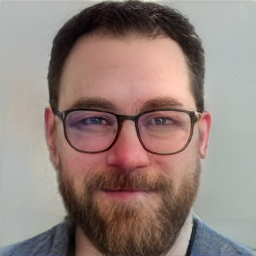

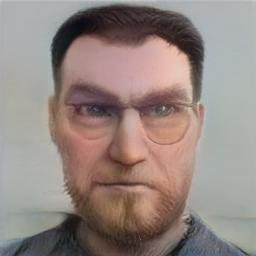

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
from IPython.display import Image 
embedded = Image(filename="generated/example_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_01-toon.jpg", width=256)
display(tooned)

# Going further with animations!

To round off this ML example, let's animate this image  with Pytorch and Aliaksanr first order motion 

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
!git clone https://github.com/AliaksandrSiarohin/first-order-model

/content/Northern-Data-Star-Wars-GAN/stylegan2
fatal: destination path 'first-order-model' already exists and is not an empty directory.


In [ ]:
try: # set up path
    import sys
    sys.path.append('/content/Northern-Data-Star-Wars-GAN/stylegan2/first-order-model')
    print('Path added')
except Exception as e:
    print(e)
    pass

Path added


Now we download the pre-trained weights for the keypoint detector and the video generator. The file is about 600 MB and may take a while to download. If the wget download fails, you can manually download the file and move it to your colab.

In [ ]:
!gdown "https://drive.google.com/uc?export=download&id=1jmcn19-c3p8mf39aYNXUhdMqzqDYZhQ_" -O vox-cpk.pth.tar

Downloading...
From: https://drive.google.com/uc?export=download&id=1jmcn19-c3p8mf39aYNXUhdMqzqDYZhQ_
To: /content/Northern-Data-Star-Wars-GAN/stylegan2/vox-cpk.pth.tar
729MB [00:04, 164MB/s]


Load the model


In [ ]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='first-order-model/config/vox-256.yaml', 
                            checkpoint_path='vox-cpk.pth.tar')

Download the source video, you can use your own or use the sample video.

In [ ]:
%cd /content/Northern-Data-Star-Wars-GAN/stylegan2
!wget https://www.dropbox.com/s/s9nrzq9hqevejrh/Bellapoarch%20TikTok%20_It_s%20M%20To%20The%20B%22.mp4 -O src_video.mp4


/content/Northern-Data-Star-Wars-GAN/stylegan2
--2021-02-24 20:14:50--  https://www.dropbox.com/s/s9nrzq9hqevejrh/Bellapoarch%20TikTok%20_It_s%20M%20To%20The%20B%22.mp4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s9nrzq9hqevejrh/Bellapoarch%20TikTok%20_It_s%20M%20To%20The%20B%22.mp4 [following]
--2021-02-24 20:14:51--  https://www.dropbox.com/s/raw/s9nrzq9hqevejrh/Bellapoarch%20TikTok%20_It_s%20M%20To%20The%20B%22.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf23a5796df292eb68fbabd232.dl.dropboxusercontent.com/cd/0/inline/BJl5feL9X-jVrS34srnHmABKBJxd0nDqP3NINcSBqxw3-NeNHdS-J8YVlk8_XuMMemtf-zn-kxYg5m6TSM1bLuYL6M7Ll2BVDf40Xv3zipkUPnj6Yqi9KSk_Reu47J9YLrA/file# [following]
--2021-02-24 20:14:51--  https://ucaf2

# To conclude this notebook, we generate and display the animation. Feel free to download it and share it on social media!

In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

from demo import make_animation
from skimage import img_as_ubyte

import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('generated/example_01-toon.jpg')
reader = imageio.get_reader('src_video.mp4')


#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

# Generate animation
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 410/410 [00:16<00:00, 24.52it/s]


If you want to download the video you created and share it with friends, run the cell and you will find the video under the path at /content/Northern-Data-Star-Wars-GAN/stylegan2/Final_video.mp4

In [ ]:
import moviepy.editor as mp
imageio.mimsave('generated.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)
my_clip = mp.VideoFileClip(r"src_video.mp4")
my_clip.audio.write_audiofile(r"src_video_audio.mp3")

videoclip = mp.VideoFileClip("generated.mp4")
audioclip = mp.AudioFileClip("src_video_audio.mp3")

new_audioclip = mp.CompositeAudioClip([audioclip])
videoclip.audio = new_audioclip
videoclip.write_videofile("Final_video.mp4", codec='libx264', audio_codec="aac")

[MoviePy] Writing audio in src_video_audio.mp3


100%|██████████| 303/303 [00:00<00:00, 1015.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Building video Final_video.mp4
[MoviePy] Writing audio in Final_videoTEMP_MPY_wvf_snd.mp4


100%|██████████| 304/304 [00:00<00:00, 539.50it/s]

[MoviePy] Done.
[MoviePy] Writing video Final_video.mp4



100%|██████████| 410/410 [00:01<00:00, 272.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Final_video.mp4 

